# Assignment 2 - Image recognition, face recognition, and embedding using Keras and TensorFlow.
## Name: Dhaval Salwala (1823085)

##  Part 1: Program a network in Keras with a triplet loss function

* Recognition of handwritten digits from the MNIST database.
We have implemented one-shot image recognition without re-training and using just one example image of each using Tripple Loss.

* This method is based on learning a Euclidean embedding per image using a deep convolutional network. 

* Triplet loss function takes advantage of the fact that two images of the same person will map to similar points in the embedding and two images of different people will map to far-away points in the embedding.

* The network is trained such that the squared L2 distances in the embedding space directly correspond to face similarity: faces of the same person have small distances and faces of distinct people have large distances.

### Loading all required libraries

In [0]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras import optimizers
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

Using TensorFlow backend.


### Loading data from MNIST data set into training and test variables.

In [0]:
############## DATA ###########################

# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


### Pre-Processing 
* Reshaping the Image data into size 28x28x1 to be valid.

* Convert type to float32.

* Normalize to prevent issues with model.

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Triplet Pair Creation
* a: Anchor image

* p: Positive image which is same as Anchor.

* n: Negative image which is competely different from a and p.

* We want out triplet loss function to map a and p as close to each other while pushing a and n apart.

In [0]:
# Get Image when the label of A and P are same
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]

# Create Triplet Pair randomly.
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

# Create a generator of tripet pair data.
# Generator will return a numpy array batch_size=100 triplet pairs on each yield.
def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label

### Implementation of Triplet Loss Fuction

In [0]:
############## Loss ###########################

def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x):
    
    anchor, positive, negative = x
    
    positive_loss = K.sum(K.square(anchor-positive),axis=1)
    negative_loss = K.sum(K.square(anchor-negative),axis=1)
    
    basic_loss=positive_loss - negative_loss + alpha 
    loss = K.maximum(basic_loss,0.0)
    return loss

### Base Model

* Architecture: **LeNet-5** – A Classic CNN Architecture [1]

* We have used LeNet-5 architecture for our base model because it makes use of a convolutional neural network (CNN). CNN's are the foundation of modern state-of-the-art deep learning-based computer vision. The network learns the best internal representation from raw images automatically. [3]

* The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier. [3]

* It is important to highlight that each image in the MNIST data set has a size of 28 X 28 pixels. So we have used a same dimension for LeNet-5 input.

* We have dropped out softmax layer from the top as we need only an embeddings of the image to further our cause in the triplet loss optimisation.

* We have set the dimension of the embeddng as 2 as MNIST is simple and 2D is best enough for visualisation.

In [0]:
############## Model ###########################

def embedding_model():

    model = Sequential()

    model.add(Convolution2D(filters=6, kernel_size = (5,5), strides = (1,1), activation='tanh', input_shape=(28,28,1), padding='same', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
    model.add(Convolution2D(filters=16, kernel_size = (5,5), strides = (1,1), activation='tanh', input_shape=(28,28,1), padding='valid', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
    model.add(Convolution2D(filters=120, kernel_size = (5,5), strides = (1,1), activation='tanh', input_shape=(28,28,1), padding='valid', use_bias=True))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(embedding_dim))
    
    model.name="embeddings"
    return model

### Complete Model

* We run our base model three times each for Anchor , Positive and Negative image.

* We then use Lamda to feed out triplet loss function to our complete model.

* We have used Adam optimiser to make our model more efficient.

In [0]:
def complete_model(base_model):
    
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))

    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model

### Configuration

In [0]:
############## Settings ###########################

imsize = 28 # for MNIST dataset

# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 
embedding_dim = 2
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 50
alpha = 0.2 # interesting to think about different values


############## Main ###############################

# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

# instantiating the model
base_model = embedding_model()
model = complete_model(base_model)
print(model.summary())

H = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    workers=1,
                    steps_per_epoch=20, 
                    validation_steps=30)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
embeddings (Sequential)         (None, 2)            61026       input_7[0][0]                    
                                                                 input_8[0][0]                    
          

#### Reporting the value of the loss function over time using a plot

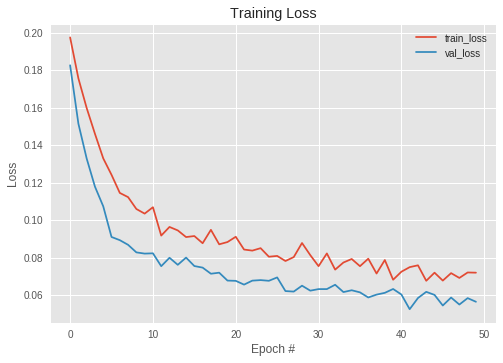

In [0]:
# plot the training loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Results

* From the above graph, we can say that the training and validation errors go down as our model learn embeddings of MNIST data set.

* There are high chances that with few more epcohs, we can bring down the error rate to almost zero but that would overfit out model to training data set.

* Hence, we can say that our model has leant optimum parameters about the input data.

### Analysis

* We now find embeddings of all the training images using our base model. The base model has already learnt weights from the training.

In [0]:
#embeddings of 60000 training images
train_embeddings=base_model.predict(X_train)
#embeddings of 10000 test images
test_embeddings=base_model.predict(X_test)

#### Image Recognition Function:

* It takes raw image array as an input.

* It gives a numpy array of predicted classes as an output.

* It uses Euclidean distance to find the class of an input image.

* Predicted class includes number 0-9 for all the digits and 10 for all unknown classes.

* We have choosen threshold as 0.0016 for our image database. All images having min distance above 0.0016 are proected as unknown.

In [0]:
def detect_digits(X_test):
    predicted_class = []
    query_embedding = base_model.predict(X_test)    
    for query in query_embedding:
        dist=euclidean_distances(train_embeddings,query.reshape(1, -1))
        if np.min(dist) < 0.0016:
            predicted_class.append(y_train[np.argmin(dist)])
        else:
            predicted_class.append(10)
    
    return np.array(predicted_class)

#### Test Data Set

* We predict classes of below 3 images using our recognition function.

* We verify out test images by visualising them as below

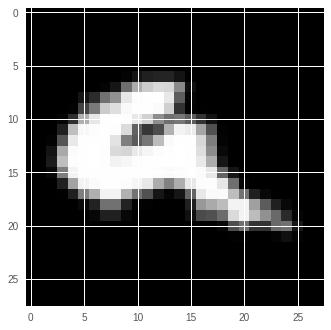

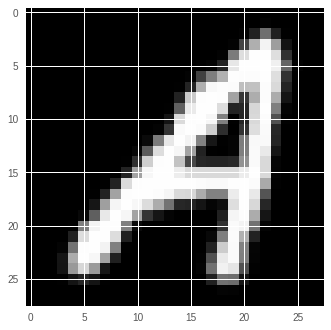

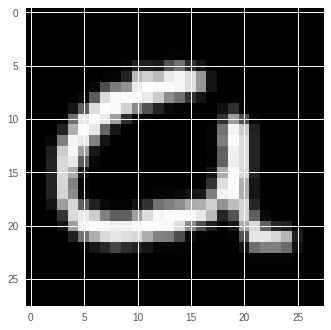

In [0]:
test_images=np.load('/content/drive/My Drive/Machine Learning/emnist_train_images_3.npy')

pixels = test_images[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
pixels = test_images[1].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
pixels = test_images[2].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

#### Predictions

* All the 3 predicted classes are 10 which indicates an unknown image.

In [0]:
#Predicting the class of the test data.
#Sample images taken are characters ['a','A','a']
detect_digits(test_images)

array([10, 10, 10])

### Training a Neural Network on Embeddings.

* We created another neural network to train our model on embeddings and output appropriate class.

* We used relu activation on the input layer and softmax layer with 10 classes on the output.

* We then test our new model on MINST Test data set.

* Our model achieves an accuarcy of approx **70%** on MNIST test data.

In [0]:
model2 = Sequential()
model2.add(Dense(32, input_shape=(2,), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))
opt = optimizers.adam()
model2.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model2.summary()
epoch_2=200
H2 = model2.fit(train_embeddings, to_categorical(y_train), verbose=1, epochs=epoch_2,
              validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                96        
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
Total params: 426
Trainable params: 426
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/200
54000/54000 [==============================] - 3s 53us/step - loss: 1.2486 - acc: 0.5467 - val_loss: 0.8323 - val_acc: 0.7162
Epoch 2/200
54000/54000 [==============================] - 2s 39us/step - loss: 1.0105 - acc: 0.6287 - val_loss: 0.7940 - val_acc: 0.7188
Epoch 3/200
54000/54000 [==============================] - 2s 39us/step - loss: 0.9

#### Visualising Loss and Accuracy of new model 

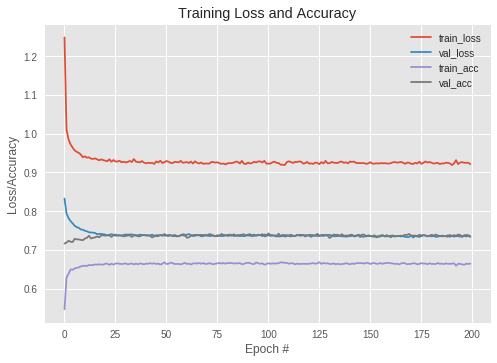

In [0]:
N = np.arange(0, epoch_2)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.plot(N, H2.history["acc"], label="train_acc")
plt.plot(N, H2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### Model Accuarcy: Predicting classes on MNIST Test Data

In [0]:
y_pred=model2.predict_classes(test_embeddings)
print ("Accuracy: ")
accuracy_score(y_test, y_pred)

Accuracy: 


0.705

## Conclusion

* We were able to test out model on MNIST test data set with 70% accuracy. 

* Our base model based on LeNet-5 architecture was able to achieve error rate below 1% on the MNIST data set.

* Our new model seems to be overcome some initial poor performance and might be able to continue improving with more training. As the model becomes more complex, and as information about error has to propagate through more layers.

* We also saw that our recognition function was able to differentiate between a digit and an unknown image based on the Euclidean distance between the embeddings.

## References

* [1] LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P. (1998). Gradient Based Learning applied to Document Recognition. [online] Yann.lecun.com. Available at: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf [Accessed 8 Apr. 2019].

* [2] Scikit-learn.org. (2019). sklearn.metrics.pairwise.euclidean_distances — scikit-learn 0.20.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html [Accessed 8 Apr. 2019].

* [3] Pechyonkin, M. (2019). Key Deep Learning Architectures: LeNet-5. [online] Medium. Available at: https://medium.com/@pechyonkin/key-deep-learning-architectures-lenet-5-6fc3c59e6f4 [Accessed 8 Apr. 2019].